## Training VGG 16 Model on FLAME Dataset

Transfer Learning is used in this work for model traning and fine-tunning.

### Steps shown below :

![caption](files/model_fc.jpg)


### 1 Load the libraries

In [15]:
import numpy as np
import datetime
import cv2 
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Activation,Conv2D,Dense,MaxPool2D,Dropout,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from IPython.display import Image, display
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,accuracy_score,classification_report
from tensorflow.keras.applications import InceptionV3,Xception,EfficientNetB3
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model
from keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

### we define the paths of images and initialization of some parameters like image size and batch

In [3]:
Base_directory = 'C:/Users/smrut/Desktop/Study/University_of_Essex/Data Science and Decision Making/Project_Data'  #'/kaggle/input/flamedatasetfireclassification'
test_path = 'Test' #'Test/Test'
Training_path = 'Training' #'Training/Training'
input_shape = (254,254,3)
batch = 16
labels = ['Fire','No_Fire']

#defining the full path for the files
Full_Training_path = '{0}/{1}'.format(Base_directory,Training_path)
Full_Test_path = '{0}/{1}'.format(Base_directory,test_path)


### 3. Data Analysis

Displaying few sample images from each class


 FIRE


<Figure size 432x288 with 0 Axes>

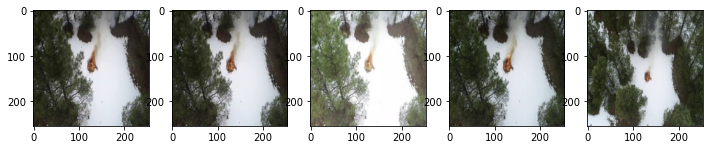

There are  25018  images in  Fire class

 NO_FIRE


<Figure size 432x288 with 0 Axes>

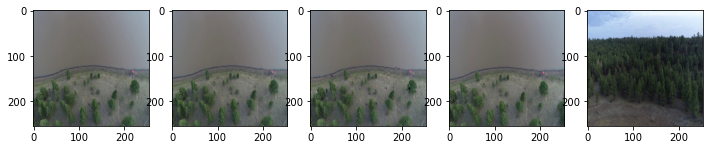

There are  14357  images in  No_Fire class


In [6]:
num = []
for label in labels:
    path = '{0}/{1}/'.format('C:/Users/smrut/Desktop/Study/University_of_Essex/Data Science and Decision Making/Project_Data/Training',label)
    folder_data = os.listdir(path)
    k = 0
    fig = figure()
    f,ax = plt.subplots(1,5,figsize=(12, 6))
    print('\n', label.upper())
    for image_path in folder_data:
        if k < 5:           
            image = imread(path+image_path)           
            ax[k].imshow(image)                        
        k = k+1
    num.append(k)
    plt.show()
    print('There are ', k,' images in ', label, 'class')

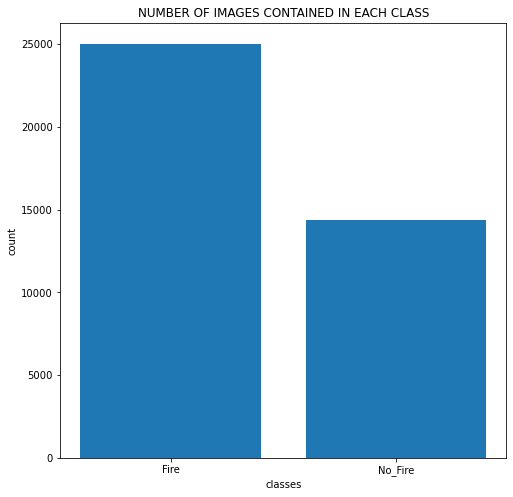

In [7]:
plt.figure(figsize = (8,8))
plt.bar(labels, num)
plt.title('NUMBER OF IMAGES CONTAINED IN EACH CLASS')
plt.xlabel('classes')
plt.ylabel('count')
plt.show()

### Image Augmentation is an important step. We pass the image to ImageDataGenerator.

In [8]:
#loading the train images to imagegenerator. We keep 20% of the data for validation
train_images = ImageDataGenerator(rotation_range=45,   #To rotate the image by max 45 degree
                                 horizontal_flip=True, # Flip horizontally
                                 vertical_flip=True,   # flip vertically                                  
                                 rescale=1.0/255,      # re-scale the RGB values between 0-1
                                 zoom_range=0.4,       # Zoom by factor 0.4
                                 shear_range=0.2,      # shear by factor 0.2
                                 fill_mode='nearest',  #fill the pixel by nearest value
                                 validation_split=0.2) # split the training set for validation - 20%

train_generator = train_images.flow_from_directory(Full_Training_path, 
                                               target_size=(254,254), #Set tge target image size 
                                               color_mode='rgb',      # generate color images
                                               class_mode='binary',   # target classes - 2 
                                               batch_size=batch,      # batch size set to 16
                                               #shuffle=True,
                                               subset='training')

validation_generator = train_images.flow_from_directory(Full_Training_path, 
                                                    target_size=(254,254),
                                                    color_mode='rgb',
                                                    class_mode='binary',
                                                    batch_size=batch,
                                                    #shuffle=True,
                                                    subset='validation')

test_images = ImageDataGenerator(rescale=1.0/255)  # re-scale the RGB values between 0-1 

test_generator = test_images.flow_from_directory(Full_Test_path, 
                                                target_size=(254,254), 
                                                color_mode='rgb', 
                                                class_mode='binary',
                                                shuffle=False,
                                                batch_size=batch)

Found 31501 images belonging to 2 classes.
Found 7874 images belonging to 2 classes.
Found 8617 images belonging to 2 classes.


In [9]:
	# create model
img_input = Input(shape=input_shape)

model = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=img_input,
    input_shape=input_shape,
    pooling='avg'
)
last_layer = model.output
x = Flatten(name='flatten')(last_layer)
x = Dense(1024, activation='relu', name='fc1')(x)
out = Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation
             ='linear')(x)  ## 2 classes
model = Model(img_input, out)

for layer in model.layers[:-60]:
    layer.trainable = False
    

87916544/87910968 [==============================] - 14s 0us/step


In [10]:
from keras.callbacks import Callback

class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        testset = self.test_data
        loss, acc = self.model.evaluate(testset, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))
        
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1),
    ModelCheckpoint(filepath='Inception_2504_{epoch:02d}_{val_accuracy:.04f}.h5',
                    save_best_only=False),
    TestCallback(test_generator)]    

In [11]:
model.compile( loss = 'hinge',
      optimizer='AdaMax',  #AdaMax
      metrics='accuracy')


In [2]:
#Training Process   
history = model.fit(train_generator,
            epochs=50,
            validation_data = validation_generator,            
            callbacks=my_callbacks,
            verbose=1    )

Found 31501 images belonging to 2 classes.
Found 7874 images belonging to 2 classes.
Found 8617 images belonging to 2 classes.
87916544/87910968 [==============================] - 1s 0us/step
Epoch 1/50
1969/1969 [==============================] - 803s 403ms/step - loss: 0.1232 - accuracy: 0.9624 - val_loss: 0.0596 - val_accuracy: 0.9813

Testing loss: 0.6802847981452942, acc: 0.7333178520202637

Epoch 2/50
1969/1969 [==============================] - 525s 267ms/step - loss: 0.0224 - accuracy: 0.9919 - val_loss: 0.0332 - val_accuracy: 0.9887

Testing loss: 0.3908836543560028, acc: 0.7965649366378784

Epoch 3/50
1969/1969 [==============================] - 524s 266ms/step - loss: 0.0195 - accuracy: 0.9922 - val_loss: 0.0286 - val_accuracy: 0.9886

Testing loss: 0.33864709734916687, acc: 0.8247650265693665

Epoch 4/50
1969/1969 [==============================] - 524s 266ms/step - loss: 0.0158 - accuracy: 0.9934 - val_loss: 0.0662 - val_accuracy: 0.9742

Testing loss: 0.581627607345581, a

In [12]:
#load the saved model. have saved the model in json format 
json_file = open('{0}/{1}'.format(Base_directory, 'Xception_saved_model.json'), 'r')
loaded_model_json = json_file.read()
json_file.close()

#define the model
#model = model_from_json(loaded_model_json)

#load the weights
model.load_weights('{0}/{1}'.format(Base_directory, 'Inception_saved_weights.h5'))

In [13]:
#Make prediction on test set
y_pred = model.predict(test_generator)

In [16]:
#convert the output to binary form 0 and 1
y_pred = [1 if x>0.5 else 0 for x in y_pred]

#Actaul test class
y_true = test_generator.classes

accuracy = accuracy_score(y_true, y_pred)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_true, y_pred)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_true, y_pred)
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true, y_pred)
print('F1 score: %f' % f1)

Accuracy: 0.849484
Precision: 0.856583
Recall: 0.753448
F1 score: 0.801712
